In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
! pip install pytorch_lightning --quiet
! pip install neptune-client==0.9.1 --quiet

     |████████████████████████████████| 808kB 24.4MB/s 
     |████████████████████████████████| 829kB 52.1MB/s 
     |████████████████████████████████| 645kB 49.9MB/s 
     |████████████████████████████████| 276kB 35.6MB/s 
     |████████████████████████████████| 122kB 48.3MB/s 
     |████████████████████████████████| 10.6MB 46.1MB/s 
     |████████████████████████████████| 1.3MB 42.7MB/s 
     |████████████████████████████████| 143kB 54.7MB/s 
     |████████████████████████████████| 296kB 53.5MB/s 
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
     |████████████████████████████████| 215kB 31.2MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
     |████████████████████████████████| 174kB 50.2MB/s 
     |████████████████████████████████| 133kB 55.6MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 


In [ ]:
import neptune.new as neptune
run = neptune.init(project='eduardocoraca/aula10', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmMzZmYmY3MC01NWJjLTQ1MjItYmVjMC0zNGNjNGZiMDA4YzcifQ==')

https://app.neptune.ai/eduardocoraca/aula10/e/AU10-9


# Inicialização

## Carregando o Dataset

In [ ]:
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

--2021-06-08 12:31:22--  http://files.fast.ai/data/examples/imdb_sample.tgz
Resolving files.fast.ai (files.fast.ai)... 172.67.69.159, 104.26.3.19, 104.26.2.19, ...
Connecting to files.fast.ai (files.fast.ai)|172.67.69.159|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.fast.ai/data/examples/imdb_sample.tgz [following]
--2021-06-08 12:31:22--  https://files.fast.ai/data/examples/imdb_sample.tgz
Connecting to files.fast.ai (files.fast.ai)|172.67.69.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571827 (558K) [application/x-gtar-compressed]
Saving to: ‘imdb_sample.tgz’

imdb_sample.tgz     100%[===================>] 558.42K  --.-KB/s    in 0.05s   

2021-06-08 12:31:22 (11.5 MB/s) - ‘imdb_sample.tgz’ saved [571827/571827]



In [ ]:
import pandas as pd
df = pd.read_csv('imdb_sample/texts.csv')
df.shape
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [ ]:
treino = df[df['is_valid'] == False]
test = df[df['is_valid'] == True]

print('treino.shape:', treino.shape)
print('test.shape:', test.shape)

X_treino_val = treino['text']
Y_treino_val = treino['label']
X_test = test['text']
Y_test = test['label']

train_split = 0.8

idx = np.arange(0,len(X_treino_val))
np.random.shuffle(idx)

train_idx = idx[0:int(train_split*len(idx))]
valid_idx = idx[int(train_split*len(idx)):]

X_treino = X_treino_val[train_idx]
X_valid = X_treino_val[valid_idx]

Y_treino = Y_treino_val[train_idx]
Y_valid = Y_treino_val[valid_idx]

print(X_treino.shape, Y_treino.shape)
print(X_valid.shape, Y_valid.shape)

mapeamento = {'positive': True, 'negative': False}
Y_treino_bool = Y_treino.map(mapeamento)
Y_valid_bool = Y_valid.map(mapeamento)
Y_test_bool = Y_test.map(mapeamento)
print(Y_treino_bool.head())

treino.shape: (800, 3)
test.shape: (200, 3)
(640,) (640,)
(160,) (160,)
537     True
378    False
636    False
766     True
7      False
Name: label, dtype: bool


In [ ]:
X_treino = np.array(X_treino)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

Y_treino = np.array(Y_treino)
Y_valid = np.array(Y_valid)
Y_test = np.array(Y_test)

## Carregando embeddings pré-treinados

In [ ]:
!wget -nc http://nlp.stanford.edu/data/glove.6B.zip
!unzip -o glove.6B.zip -d glove_dir

--2021-06-08 12:31:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-08 12:31:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-08 12:31:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
from torchtext.vocab import GloVe

glove_dim = 300

glove_vectors = GloVe(name='6B', dim=glove_dim, cache='./glove_dir')
glove_vocab = glove_vectors.stoi # usando os mesmos índices do Glove
glove_matrix = glove_vectors.vectors # matriz de embeddings (V x emb_dim)

100%|█████████▉| 399215/400000 [00:35<00:00, 11097.34it/s]

Adicionando duas dimensões à matriz de Embeddings:

*   len(vocab) + 1: retorna a média dos Embeddings de todos os tokens, utilizado para tokens desconhecidos;
*   len(vocab) + 2: retorna um vetor de zeros, utilizado para Padding.

tokens desconhecidos

In [ ]:
embeddings = torch.vstack((glove_matrix, glove_matrix.mean(axis=0, keepdims=True), torch.zeros((1,glove_matrix.shape[1]))))

print(embeddings.shape)

torch.Size([400002, 300])


# Tokenizador e Vocabulário

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

import torch
from torch.utils.data import DataLoader

import numpy as np
from collections import Counter

In [ ]:
class Tokenizer():
    def __init__(self, vocab):
        self.tokenizer = get_tokenizer('basic_english')
        self.vocab = vocab
    
    def tokenize(self, x):
        out = []
        for token in self.tokenizer(x):
            if token in self.vocab.keys():
                out.append(self.vocab[token])
            else:
                out.append(len(self.vocab)) # para termos desconhecidos
        return out  

In [ ]:
tokenizer = Tokenizer(vocab = glove_vocab)
tokenizer.tokenize('test one two three teste_palavra_desconhecida')

[728, 48, 55, 87, 400000]

# Dataset 

Tamanho de cada exemplo do conjunto de treino:

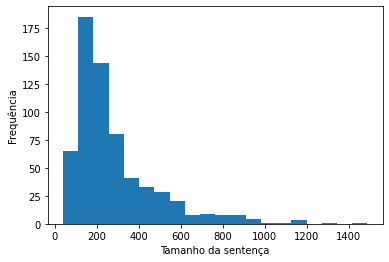

In [ ]:
lens = list(map(lambda x: len(tokenizer.tokenize(x)), X_treino))
plt.hist(lens, bins=20);
plt.ylabel('Frequência');
plt.xlabel('Tamanho da sentença');

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, tokenizer, max_dim):
        '''
        max_dim: tamanho máximo da sentença para aplicar padding ou truncar
        '''    

        self.X = X
        self.Y = Y
        self.tokenizer = tokenizer
        self.max_dim = max_dim

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        if self.Y[idx] == 'positive':
            label = 1
        else:
            label = 0

        x_id = self.tokenizer.tokenize(self.X[idx]) # retorna o índice no vocab
        
        x = x_id
        if len(x_id) > self.max_dim: # truncando
            x = x_id[0:self.max_dim]

        if len(x_id) < self.max_dim:
            x = torch.ones(self.max_dim)*(len(self.tokenizer.vocab) + 1) # token de padding: len(vocab) + 1
            x[0:len(x_id)] = torch.LongTensor(x_id)            

        return torch.Tensor(x), label

# Modelo

In [ ]:
class Modelo(torch.nn.Module):
    def __init__(self, hidden_dim, embeddings, dropout=0):
        super(Modelo, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings, freeze=True)
        self.dropout = torch.nn.
        self.linear1 = torch.nn.Linear(embeddings.shape[1], hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, 2)
        self.relu = torch.nn.ReLU()

    def self_attention(self, emb):
        # embeddings: (batch_size, n_palavras, embedding_dim)

        batch_size = emb.shape[0]
        n_palavras = emb.shape[1]
        n_embedding = emb.shape[2]
        E = []
        for batch in range(batch_size):    # loop para cada batch
            idx_palavras = torch.arange(0, n_palavras)[abs(emb[batch]).sum(dim=1) > 0] # array de palavras que não são padding
            idx_padding = torch.arange(idx_palavras[-1]+1, n_palavras)

            E_batch = []
            for i in idx_palavras:    # loop para cada palavra de entrada que não é padding
                s = []
                for j in idx_palavras:
                    s.append( torch.matmul( emb[batch, i], emb[batch, j]) )
                    
                p = torch.softmax(torch.Tensor(s), dim=0) # probabilidades
                soma = 0
                for k in range(len(idx_palavras)):  # apenas para palavras que não são padding
                    soma += p[k]*emb[batch,idx_palavras[k]]
                    
                E_batch.append(soma)
                
            E_batch_mean = torch.stack(E_batch).mean(dim=0)
            E.append(E_batch_mean)

        return torch.stack(E)

    def self_attention_old(self, embeddings):
        # embeddings: (batch_size, n_palavras, embedding_dim)

        with torch.no_grad():
            batch_size = embeddings.shape[0]
            n_palavras = embeddings.shape[1]
            n_embedding = embeddings.shape[2]
            E = []
            for batch in range(batch_size):    # loop para cada batch
                idx_palavras = torch.arange(0, n_palavras)[abs(embeddings[batch]).sum(dim=1) > 0] # array de palavras que não são padding
                idx_padding = torch.arange(idx_palavras[-1]+1, n_palavras)

                E_batch = []
                for i in idx_palavras:    # loop para cada palavra de entrada
                    s = []
                    for j in idx_palavras:
                        s.append( torch.matmul( embeddings[batch, i], embeddings[batch, j]) )
                    #for j in idx_padding:
                    #    s.append(-1e9)
                    
                    p = torch.softmax(torch.Tensor(s), dim=0) # probabilidades
                    soma = 0
                    for k in range(idx_palavras):
                        soma += p[k]*embeddings[batch,idx_palavras[k]]
                    
                    E_batch.append(soma)

                #for i in idx_padding:
                #    E_batch.append(0*E_batch[0]) # valor 0 para os paddings
                
                E_mean.append(torch.stack(E_batch))
            
            return torch.stack(E)

    def forward(self, x):
        x = self.embedding(x.long())
        x = self.self_attention(x)
        #x = x.mean(axis=1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)

        return x

# Modelo Lightning

In [ ]:
import pytorch_lightning
from pytorch_lightning import LightningModule, Trainer

In [ ]:
class LightningClassifier(LightningModule):
    def __init__(self, hparams, modelo, log_run=False):
        super().__init__()

        self.log_run = log_run
        self.save_hyperparameters(hparams)
        self.criterion = torch.nn.CrossEntropyLoss(reduction='none')
        self.model = modelo

    def forward(self, x):
        logits = self.model(x)
        preds = logits.argmax(dim=1)
        return logits, preds

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.model(x.long())

        batch_losses = self.criterion(logits, y)
        loss = batch_losses.mean()       
        if self.log_run == True:
            run['train/batch_loss'].log(loss)

        return {'loss': loss, 'batch_losses': batch_losses}

    def training_epoch_end(self, outputs):
        avg_loss = torch.vstack([output['batch_losses'].unsqueeze(1) for output in outputs]).mean()
        if self.log_run == True:
            run['train/loss'].log(avg_loss)
        return
  
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits, preds = self.forward(x.long())
        batch_losses = self.criterion(logits, y)
        batch_accuracy = (preds == y)
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy}

    def validation_epoch_end(self, outputs):

        avg_loss = torch.vstack([output['batch_losses'].unsqueeze(1) for output in outputs]).mean()
        accuracy = torch.vstack([output['batch_accuracy'].unsqueeze(1) for output in outputs]).float().mean()

        if self.log_run == True:
            run['valid/loss'].log(avg_loss)
            run['valid/acuracy'].log(accuracy)

        metrics = {'valid_loss': avg_loss.item()}
        output =  {'progress_bar': metrics, 'valid_loss': avg_loss.item()}

        self.log('valid_loss', avg_loss.item(), prog_bar=True)
        self.log('valid_accuracy', accuracy.item(), prog_bar=True)

        return output
  
    def test_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits, preds = self.forward(x.long())
        batch_losses = self.criterion(logits, y)
        batch_accuracy = (preds == y)

        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy}

    def test_epoch_end(self, outputs):
        avg_loss = torch.vstack([output['batch_losses'].unsqueeze(1) for output in outputs]).mean()
        accuracy = torch.vstack([output['batch_accuracy'].unsqueeze(1) for output in outputs]).float().mean()

        if self.log_run == True:
            run['valid/loss'].log(avg_loss)
            run['valid/acuracy'].log(accuracy)

        metrics = {'Test loss': avg_loss.item(), 'test accuracy': accuracy.item()}
        output =  {'progress_bar': metrics}
        
        self.log('test_loss', avg_loss.item())
        self.log('test_accuracy', accuracy.item())

        return output

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams['learning_rate'], weight_decay=self.hparams['weight_decay'])
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: self.hparams['multiplicative_lr'])
        return [optimizer], [scheduler]

# Treinamento

In [ ]:
hparams = {
    'max_epochs': 10,
    'learning_rate': 0.01,
    'hidden_dim': 100,
    'weight_decay': 0,
    'multiplicative_lr': 0.9,
    'max_words': 50
}

In [ ]:
batch_size = 25

train_dataset = Dataset(X_treino, Y_treino, tokenizer, max_dim=hparams['max_words'])
val_dataset = Dataset(X_valid, Y_valid, tokenizer, max_dim=hparams['max_words'])
test_dataset = Dataset(X_test, Y_test, tokenizer, max_dim=hparams['max_words'])

train_dataloader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

Treinando por poucas épocas pois é muito lento

In [ ]:
modelo = Modelo(hidden_dim = hparams['hidden_dim'],
                embeddings = embeddings)

pl_model = LightningClassifier(hparams = hparams, modelo = modelo, log_run=True)
trainer = Trainer(max_epochs = hparams['max_epochs'], gpus=1)

trainer.fit(pl_model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | Modelo           | 120 M 
-----------------------------------------------
30.3 K    Trainable params
120 M     Non-trainable params
120 M     Total params
480.124   Total estimated model params size (MB)


# Self-attention matricial

Usei o método .masked_fill baseado no código do Orlem;

Para o cálculo da média de E apenas do que não é padding eu me baseei no código do link: https://www.codefull.net/2020/03/masked-tensor-operations-in-pytorch/

In [ ]:
class Modelo2(torch.nn.Module):
    def __init__(self, hidden_dim, embeddings):
        super(Modelo2, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings, freeze=True)

        self.linear1 = torch.nn.Linear(embeddings.shape[1], hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = torch.nn.Linear(hidden_dim, 2)
        self.relu = torch.nn.ReLU()

    def self_attention(self, emb):
        with torch.no_grad():
            padding = ~((emb==0).sum(axis=2) == emb.shape[2]) # detectando o que não é Padding (True) e o que é Padding (False)
            mask = torch.tile(padding.unsqueeze(-1), (1,1,emb.shape[2])) # criando um tensor de máscaras de dim (batch, num_words, num_embedding)

            Q = emb.clone()
            K = emb.clone()
            V = emb.clone()

            scores = torch.matmul(Q, K.permute(0,2,1))
            scores = scores.masked_fill(scores==0, -1e9) # scores==0 -> resultado do produto escalar de um pad com qualquer vetor

            probs = torch.softmax(scores, dim=-1)

            E = torch.matmul(probs, V)

            E_mean = torch.mul(E, mask).sum(dim=1)/mask.sum(dim=1) # calculando a média considerando apenas o que não é Padding

            return E_mean

    def self_attention_old(self, emb):
        with torch.no_grad():
            # matriz padding de booleanos:
            padding = ((emb==0).sum(axis=2) == emb.shape[2]) # igual à dimensão do embedding

            Q = emb.clone()
            K = emb.clone()
            V = emb.clone()

            scores = torch.matmul(Q, K.permute(0,2,1))
            probs = torch.softmax(scores, dim=-1)

            # produzindo uma máscara de dimensão (num_words, num_words) para cada batch
            # indicando as linhas e colunas que são padding
            num_words = padding.shape[1]
            for b in range(padding.shape[0]):
                m = padding[b].unsqueeze(0)
                mascara = (m.repeat((num_words,1)) + m.T.repeat((1,num_words))) > 0 
                scores[b,mascara] = -1e9

            probs = torch.softmax(scores, dim=-1)

            for b in range(padding.shape[0]):
                m = padding[b].unsqueeze(0)
                mascara = (m.repeat((num_words,1)) + m.T.repeat((1,num_words))) > 0 
                probs[b,mascara] = 0
            E = torch.matmul(probs, V)
        return E

    def forward(self, x):
        x = self.embedding(x.long())
        x = self.self_attention(x)
        #x = torch.mean(x, dim=1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        
        return x

In [ ]:
hparams2 = {
    'max_epochs': 40,
    'learning_rate': 0.005,
    'hidden_dim': 300,
    'weight_decay': 0,
    'dropout': 0.2;
    'multiplicative_lr': 0.9,
    'max_words': 1200,
}

In [ ]:
batch_size = 25

train_dataset2 = Dataset(X_treino, Y_treino, tokenizer, max_dim=hparams2['max_words'])
val_dataset2 = Dataset(X_valid, Y_valid, tokenizer, max_dim=hparams2['max_words'])
test_dataset2 = Dataset(X_test, Y_test, tokenizer, max_dim=hparams2['max_words'])

train_dataloader2 = DataLoader(dataset = train_dataset2, batch_size = batch_size, shuffle = True)
val_dataloader2 = DataLoader(dataset = val_dataset2, batch_size = batch_size, shuffle = False)
test_dataloader2 = DataLoader(dataset = test_dataset2, batch_size = batch_size, shuffle = False)

In [ ]:
modelo2 = Modelo2(hidden_dim = hparams2['hidden_dim'],
                embeddings = embeddings)

modelo2.embedding.weight.requires_grad = False # não treina o embedding

In [ ]:
pl_model2 = LightningClassifier(hparams = hparams2, modelo = modelo2, log_run=True)
trainer2 = Trainer(max_epochs = hparams2['max_epochs'], gpus=1) 

trainer2.fit(pl_model2, train_dataloader2, val_dataloader2)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
100%|█████████▉| 399806/400000 [00:49<00:00, 11264.54it/s]
  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | Modelo2          | 120 M 
-----------------------------------------------
181 K     Trainable params
120 M     Non-trainable params
120 M     Total params
480.727   Total estimated model params size (MB)


In [ ]:
trainer2.test(pl_model2, test_dataloader2)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8199999928474426, 'test_loss': 0.4555957615375519}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.8199999928474426, 'test_loss': 0.4555957615375519}]